## ME5413: Autonomous Mobile Robot  

### Homework 1: Perception  


### 0. Install Packages
Prefered use of these version so that the code can be run during evaluation

In [60]:
# !pip install numpy==1.23
# !pip install torch==2.1.0
# !pip install transformers==4.48.1
# !pip install timm==1.0.14
# !pip install matplotlib

In [61]:

import cv2, torch, transformers, timm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os, glob
from transformers import AutoImageProcessor, DetrForObjectDetection

print("All packages loaded successfully!")


All packages loaded successfully!


In [62]:
def compute_iou(box1, box2):
    """Compute Intersection over Union (IoU) between two bounding boxes."""
    x1_min, y1_min, w1, h1 = box1
    x1_max, y1_max = x1_min + w1, y1_min + h1

    x2_min, y2_min, w2, h2 = box2
    x2_max, y2_max = x2_min + w2, y2_min + h2

    # Compute intersection
    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)

    inter_area = max(0, inter_x_max - inter_x_min) * max(0, inter_y_max - inter_y_min)

    # Compute union
    area1 = w1 * h1
    area2 = w2 * h2
    union_area = area1 + area2 - inter_area

    # Compute IoU
    iou = inter_area / union_area if union_area > 0 else 0
    return iou

def bbox_center(bbox):
    """Compute the center (x, y) of a bounding box in (x, y, w, h) format."""
    x, y, w, h = bbox
    return np.array([x + w / 2, y + h / 2])

## Task 1.1 Single-Object Tracking 


### USING TEMPLATE MATCHING

### Sequence 1

(951, 287, 54, 134) are the ground turth bounding box coordinates


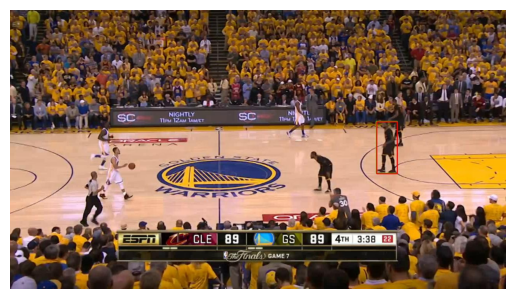

Above image is Showing the bounding box for the second frame of the sequence. RED IS GROUND TRUTH AND GREEN IS PREDICTED
Bounding boxes saved to trackresults_TM_seq1.txt file!
Results saved in data/seq1/results folder
Average Success for this Sequence: 0.33074135871175275
Average Euclidean Center distance between ground truth and tracked bounding for this Sequence: 172.01479621502097
Precision at 20px: 0.3667
Precision at 50px: 0.5200
Precision at 100px: 0.5800
Precision at 200px: 0.6933


In [63]:
## Checking bounding box on image

# Step 1: Read the bounding box from the file
#format: x,y,width,height
with open("data/seq1/firsttrack.txt", "r") as file:
    bbox = file.readline().strip().split(",")  # Assuming the format: x,y,width,height


x, y, w, h = map(int, bbox)
print(f"{x, y, w, h} are the ground turth bounding box coordinates")

image_path = "data/seq1/img/00000001.jpg"  # Replace with your actual image file
firstimage = cv2.imread(image_path)

color = (0, 255, 0)  # Green color for the bounding box
thickness = 2

firstimage = cv2.cvtColor(firstimage, cv2.COLOR_BGR2RGB)
cv2.rectangle(firstimage, (x, y), (x + w, y + h), color, thickness)


#CALCULATING TEMPLATE MATCHING
template = firstimage[y:y + h, x:x + w]
plt.imshow(template, cmap="gray")

# Read the ground truth bounding boxes from file
ground_truth_file = "data/seq1/groundtruth.txt"
ground_truth_bboxes = []

with open(ground_truth_file, "r") as file:
    for line in file:
        bbox = list(map(int, line.strip().split(",")))  # Assuming x,y,width,height format
        ground_truth_bboxes.append(bbox)

images_files = sorted(glob.glob("data/seq1/img/*.jpg"))
boundingboxresults=[]
ious = []
centers = []
for idx, images_path in enumerate(images_files):
    image = cv2.imread(images_path)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    x_new, y_new = max_loc
    prev_bbox = (x_new, y_new, w, h)
    boundingboxresults.append(prev_bbox)

    #image = cv2.imread(images_path)

    #DRAW BOUNDING BOXES

    cv2.rectangle(image, max_loc, (max_loc[0] + w, max_loc[1] + h), color, thickness)
    x_gt, y_gt, w_gt, h_gt = ground_truth_bboxes[idx]
    cv2.rectangle(image, (x_gt, y_gt), (x_gt + w_gt, y_gt + h_gt),(0,0 ,255), thickness)
    output_path = f"data/seq1/results/{os.path.basename(images_path)}"
    cv2.imwrite(output_path, image)

    iou = compute_iou(prev_bbox, ground_truth_bboxes[idx]) if idx < len(ground_truth_bboxes) else 0
    #print(f"IOU: {iou}")
    ious.append(iou)

    center = bbox_center(prev_bbox)
    gt_center = bbox_center(ground_truth_bboxes[idx]) if idx < len(ground_truth_bboxes) else None
    if gt_center is not None:
        distance = np.linalg.norm(center - gt_center)
        centers.append(distance)
        #print(f"✅ Precision: {distance}")
       
with open("results/1_template_matching/trackresults_TM_seq1.txt", "w") as file:
    for bbox in boundingboxresults:
        file.write(f"{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]}\n")
        
img = mpimg.imread('data/seq1/results/00000002.jpg')  # Replace with your image file path
#img_rgb = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.show()
print("Above image is Showing the bounding box for the second frame of the sequence. RED IS GROUND TRUTH AND GREEN IS PREDICTED")
print("Bounding boxes saved to trackresults_TM_seq1.txt file!")
print ("Results saved in data/seq1/results folder")
print(f"Average Success for this Sequence: {np.mean(ious)}")
print(f"Average Euclidean Center distance between ground truth and tracked bounding for this Sequence: {np.mean(centers)}")

# Define thresholds
thresholds = [20, 50, 100, 200]

# Compute precision for each threshold
for t in thresholds:
    precision = sum(d < t for d in centers) / len(centers)
    print(f"Precision at {t}px: {precision:.4f}")






### Sequence 2

(144, 231, 39, 96) are the ground turth bounding box coordinates


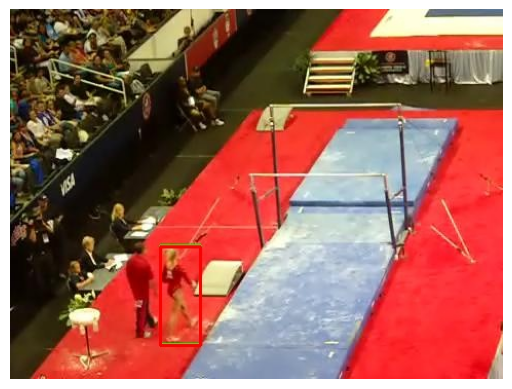

Above image is Showing the bounding box for the second frame of the sequence. RED IS GROUND TRUTH AND GREEN IS PREDICTED
Bounding boxes saved to trackresults_TM_seq2.txt file!
Results saved in data/seq2/results folder
Average Success for this Sequence: 0.477724647197338
Average Euclidean Center distance between ground truth and tracked bounding for this Sequence: 36.422374327506624
Precision at 20px: 0.6000
Precision at 50px: 0.6600
Precision at 100px: 0.9067
Precision at 200px: 0.9933


In [64]:
#Sequence 2

## Checking bounding box on image

# Step 1: Read the bounding box from the file
#format: x,y,width,height
with open("data/seq2/firsttrack.txt", "r") as file:
    bbox = file.readline().strip().split(",")  # Assuming the format: x,y,width,height


x, y, w, h = map(int, bbox)
print(f"{x, y, w, h} are the ground turth bounding box coordinates")

image_path = "data/seq2/img/00000001.jpg"  # Replace with your actual image file
firstimage = cv2.imread(image_path)

color = (0, 255, 0)  # Green color for the bounding box
thickness = 2

firstimage = cv2.cvtColor(firstimage, cv2.COLOR_BGR2RGB)
cv2.rectangle(firstimage, (x, y), (x + w, y + h), color, thickness)


#CALCULATING TEMPLATE MATCHING
template = firstimage[y:y + h, x:x + w]
plt.imshow(template, cmap="gray")

# Read the ground truth bounding boxes from file
ground_truth_file = "data/seq2/groundtruth.txt"
ground_truth_bboxes = []

with open(ground_truth_file, "r") as file:
    for line in file:
        bbox = list(map(int, line.strip().split(",")))  # Assuming x,y,width,height format
        ground_truth_bboxes.append(bbox)

images_files = sorted(glob.glob("data/seq2/img/*.jpg"))
boundingboxresults=[]
ious = []
centers = []
for idx, images_path in enumerate(images_files):
    image = cv2.imread(images_path)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    x_new, y_new = max_loc
    prev_bbox = (x_new, y_new, w, h)
    boundingboxresults.append(prev_bbox)

    #image = cv2.imread(images_path)

    #DRAW BOUNDING BOXES

    cv2.rectangle(image, max_loc, (max_loc[0] + w, max_loc[1] + h), color, thickness)
    x_gt, y_gt, w_gt, h_gt = ground_truth_bboxes[idx]
    cv2.rectangle(image, (x_gt, y_gt), (x_gt + w_gt, y_gt + h_gt),(0,0 ,255), thickness)
    output_path = f"data/seq2/results/{os.path.basename(images_path)}"
    cv2.imwrite(output_path, image)

    iou = compute_iou(prev_bbox, ground_truth_bboxes[idx]) if idx < len(ground_truth_bboxes) else 0
    #print(f"IOU: {iou}")
    ious.append(iou)

    center = bbox_center(prev_bbox)
    gt_center = bbox_center(ground_truth_bboxes[idx]) if idx < len(ground_truth_bboxes) else None
    if gt_center is not None:
        distance = np.linalg.norm(center - gt_center)
        centers.append(distance)
        #print(f"✅ Precision: {distance}")
       
with open("results/1_template_matching/trackresults_TM_seq2.txt", "w") as file:
    for bbox in boundingboxresults:
        file.write(f"{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]}\n")
        
img = mpimg.imread('data/seq2/results/00000002.jpg')  # Replace with your image file path
#img_rgb = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.show()

print("Above image is Showing the bounding box for the second frame of the sequence. RED IS GROUND TRUTH AND GREEN IS PREDICTED")

print("Bounding boxes saved to trackresults_TM_seq2.txt file!")
print ("Results saved in data/seq2/results folder")
print(f"Average Success for this Sequence: {np.mean(ious)}")
print(f"Average Euclidean Center distance between ground truth and tracked bounding for this Sequence: {np.mean(centers)}")

# Define thresholds
thresholds = [20, 50, 100, 200]

# Compute precision for each threshold
for t in thresholds:
    precision = sum(d < t for d in centers) / len(centers)
    print(f"Precision at {t}px: {precision:.4f}")


### Sequence 3

(256, 48, 175, 312) are the ground turth bounding box coordinates


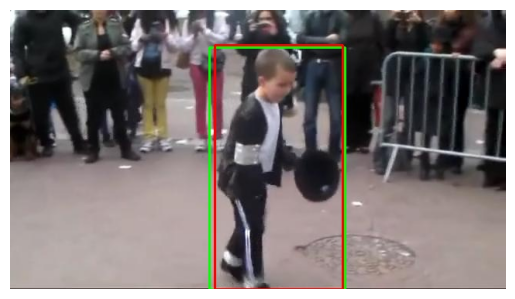

Above image is Showing the bounding box for the second frame of the sequence. RED IS GROUND TRUTH AND GREEN IS PREDICTED
Bounding boxes saved to trackresults_TM_seq3.txt file!
Results saved in data/seq3/results folder
Average Success for this Sequence: 0.11491941697397662
Average Euclidean Center distance between ground truth and tracked bounding for this Sequence: 192.2806721661561
Precision at 20px: 0.0333
Precision at 50px: 0.1067
Precision at 100px: 0.1533
Precision at 200px: 0.4733


In [65]:
with open("data/seq3/firsttrack.txt", "r") as file:
    bbox = file.readline().strip().split(",")  # Assuming the format: x,y,width,height


x, y, w, h = map(int, bbox)
print(f"{x, y, w, h} are the ground turth bounding box coordinates")

image_path = "data/seq3/img/00000001.jpg"  # Replace with your actual image file
firstimage = cv2.imread(image_path)

color = (0, 255, 0)  # Green color for the bounding box
thickness = 2

firstimage = cv2.cvtColor(firstimage, cv2.COLOR_BGR2RGB)
cv2.rectangle(firstimage, (x, y), (x + w, y + h), color, thickness)


#CALCULATING TEMPLATE MATCHING
template = firstimage[y:y + h, x:x + w]
plt.imshow(template, cmap="gray")

# Read the ground truth bounding boxes from file
ground_truth_file = "data/seq3/groundtruth.txt"
ground_truth_bboxes = []

with open(ground_truth_file, "r") as file:
    for line in file:
        bbox = list(map(int, line.strip().split(",")))  # Assuming x,y,width,height format
        ground_truth_bboxes.append(bbox)

images_files = sorted(glob.glob("data/seq3/img/*.jpg"))
boundingboxresults=[]
ious = []
centers = []
for idx, images_path in enumerate(images_files):
    image = cv2.imread(images_path)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    x_new, y_new = max_loc
    prev_bbox = (x_new, y_new, w, h)
    boundingboxresults.append(prev_bbox)

    #image = cv2.imread(images_path)

    #DRAW BOUNDING BOXES

    cv2.rectangle(image, max_loc, (max_loc[0] + w, max_loc[1] + h), color, thickness)
    x_gt, y_gt, w_gt, h_gt = ground_truth_bboxes[idx]
    cv2.rectangle(image, (x_gt, y_gt), (x_gt + w_gt, y_gt + h_gt),(0,0 ,255), thickness)
    output_path = f"data/seq3/results/{os.path.basename(images_path)}"
    cv2.imwrite(output_path, image)

    iou = compute_iou(prev_bbox, ground_truth_bboxes[idx]) if idx < len(ground_truth_bboxes) else 0
    #print(f"IOU: {iou}")
    ious.append(iou)

    center = bbox_center(prev_bbox)
    gt_center = bbox_center(ground_truth_bboxes[idx]) if idx < len(ground_truth_bboxes) else None
    if gt_center is not None:
        distance = np.linalg.norm(center - gt_center)
        centers.append(distance)
        #print(f"✅ Precision: {distance}")
       
with open("results/1_template_matching/trackresults_TM_seq3.txt", "w") as file:
    for bbox in boundingboxresults:
        file.write(f"{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]}\n")
        
img = mpimg.imread('data/seq3/results/00000002.jpg')  # Replace with your image file path
#img_rgb = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.show()

print("Above image is Showing the bounding box for the second frame of the sequence. RED IS GROUND TRUTH AND GREEN IS PREDICTED")

print("Bounding boxes saved to trackresults_TM_seq3.txt file!")
print ("Results saved in data/seq3/results folder")
print(f"Average Success for this Sequence: {np.mean(ious)}")
print(f"Average Euclidean Center distance between ground truth and tracked bounding for this Sequence: {np.mean(centers)}")

# Define thresholds
thresholds = [20, 50, 100, 200]

# Compute precision for each threshold
for t in thresholds:
    precision = sum(d < t for d in centers) / len(centers)
    print(f"Precision at {t}px: {precision:.4f}")


Sequence 4

(686, 426, 58, 171) are the ground turth bounding box coordinates


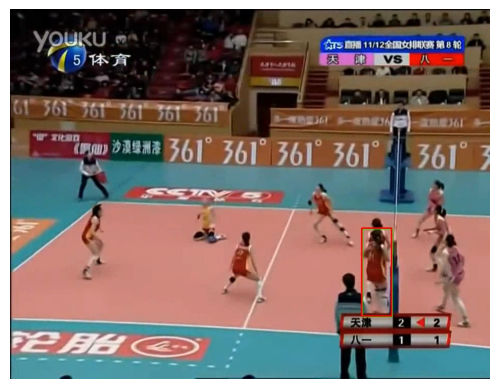

Above image is Showing the bounding box for the second frame of the sequence. RED IS GROUND TRUTH AND GREEN IS PREDICTED
Bounding boxes saved to trackresults_TM_seq4.txt file!
Results saved in data/seq3/results folder
Average Success for this Sequence: 0.22149481093091292
Average Euclidean Center distance between ground truth and tracked bounding for this Sequence: 201.07809581246835
Precision at 20px: 0.2533
Precision at 50px: 0.3200
Precision at 100px: 0.3600
Precision at 200px: 0.6533


In [66]:
with open("data/seq4/firsttrack.txt", "r") as file:
    bbox = file.readline().strip().split(",")  # Assuming the format: x,y,width,height


x, y, w, h = map(int, bbox)
print(f"{x, y, w, h} are the ground turth bounding box coordinates")

image_path = "data/seq4/img/00000001.jpg"  # Replace with your actual image file
firstimage = cv2.imread(image_path)

color = (0, 255, 0)  # Green color for the bounding box
thickness = 2

firstimage = cv2.cvtColor(firstimage, cv2.COLOR_BGR2RGB)
cv2.rectangle(firstimage, (x, y), (x + w, y + h), color, thickness)


#CALCULATING TEMPLATE MATCHING
template = firstimage[y:y + h, x:x + w]
plt.imshow(template, cmap="gray")

# Read the ground truth bounding boxes from file
ground_truth_file = "data/seq4/groundtruth.txt"
ground_truth_bboxes = []

with open(ground_truth_file, "r") as file:
    for line in file:
        bbox = list(map(int, line.strip().split(",")))  # Assuming x,y,width,height format
        ground_truth_bboxes.append(bbox)

images_files = sorted(glob.glob("data/seq4/img/*.jpg"))
boundingboxresults=[]
ious = []
centers = []
for idx, images_path in enumerate(images_files):
    image = cv2.imread(images_path)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    x_new, y_new = max_loc
    prev_bbox = (x_new, y_new, w, h)
    boundingboxresults.append(prev_bbox)

    #image = cv2.imread(images_path)

    #DRAW BOUNDING BOXES

    cv2.rectangle(image, max_loc, (max_loc[0] + w, max_loc[1] + h), color, thickness)
    x_gt, y_gt, w_gt, h_gt = ground_truth_bboxes[idx]
    cv2.rectangle(image, (x_gt, y_gt), (x_gt + w_gt, y_gt + h_gt),(0,0 ,255), thickness)
    output_path = f"data/seq4/results/{os.path.basename(images_path)}"
    cv2.imwrite(output_path, image)

    iou = compute_iou(prev_bbox, ground_truth_bboxes[idx]) if idx < len(ground_truth_bboxes) else 0
    #print(f"IOU: {iou}")
    ious.append(iou)

    center = bbox_center(prev_bbox)
    gt_center = bbox_center(ground_truth_bboxes[idx]) if idx < len(ground_truth_bboxes) else None
    if gt_center is not None:
        distance = np.linalg.norm(center - gt_center)
        centers.append(distance)
        #print(f"✅ Precision: {distance}")
       
with open("results/1_template_matching/trackresults_TM_seq4.txt", "w") as file:
    for bbox in boundingboxresults:
        file.write(f"{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]}\n")
        
img = mpimg.imread('data/seq4/results/00000002.jpg')  # Replace with your image file path
#img_rgb = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.show()

print("Above image is Showing the bounding box for the second frame of the sequence. RED IS GROUND TRUTH AND GREEN IS PREDICTED")

print("Bounding boxes saved to trackresults_TM_seq4.txt file!")
print ("Results saved in data/seq3/results folder")
print(f"Average Success for this Sequence: {np.mean(ious)}")
print(f"Average Euclidean Center distance between ground truth and tracked bounding for this Sequence: {np.mean(centers)}")

# Define thresholds
thresholds = [20, 50, 100, 200]

# Compute precision for each threshold
for t in thresholds:
    precision = sum(d < t for d in centers) / len(centers)
    print(f"Precision at {t}px: {precision:.4f}")

Sequence 5

(137, 320, 233, 191) are the ground turth bounding box coordinates


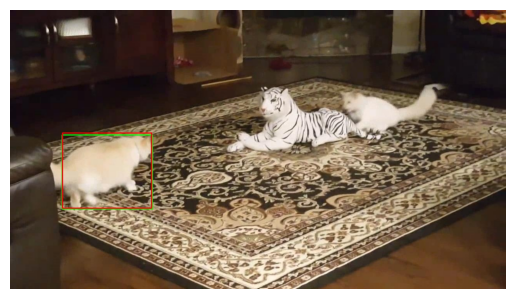

Above image is Showing the bounding box for the second frame of the sequence. RED IS GROUND TRUTH AND GREEN IS PREDICTED
Bounding boxes saved to trackresults_TM_seq5.txt file!
Results saved in data/seq5/results folder
Average Success for this Sequence: 0.6036633215486488
Average Euclidean Center distance between ground truth and tracked bounding for this Sequence: 146.93650990479372
Precision at 20px: 0.7400
Precision at 50px: 0.8200
Precision at 100px: 0.8333
Precision at 200px: 0.8333


In [67]:
with open("data/seq5/firsttrack.txt", "r") as file:
    bbox = file.readline().strip().split(",")  # Assuming the format: x,y,width,height


x, y, w, h = map(int, bbox)
print(f"{x, y, w, h} are the ground turth bounding box coordinates")

image_path = "data/seq5/img/00000001.jpg"  # Replace with your actual image file
firstimage = cv2.imread(image_path)

color = (0, 255, 0)  # Green color for the bounding box
thickness = 2

firstimage = cv2.cvtColor(firstimage, cv2.COLOR_BGR2RGB)
cv2.rectangle(firstimage, (x, y), (x + w, y + h), color, thickness)


#CALCULATING TEMPLATE MATCHING
template = firstimage[y:y + h, x:x + w]
plt.imshow(template, cmap="gray")

# Read the ground truth bounding boxes from file
ground_truth_file = "data/seq5/groundtruth.txt"
ground_truth_bboxes = []

with open(ground_truth_file, "r") as file:
    for line in file:
        bbox = list(map(int, line.strip().split(",")))  # Assuming x,y,width,height format
        ground_truth_bboxes.append(bbox)

images_files = sorted(glob.glob("data/seq5/img/*.jpg"))
boundingboxresults=[]
ious = []
centers = []
for idx, images_path in enumerate(images_files):
    image = cv2.imread(images_path)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    x_new, y_new = max_loc
    prev_bbox = (x_new, y_new, w, h)
    boundingboxresults.append(prev_bbox)

    #image = cv2.imread(images_path)

    #DRAW BOUNDING BOXES

    cv2.rectangle(image, max_loc, (max_loc[0] + w, max_loc[1] + h), color, thickness)
    x_gt, y_gt, w_gt, h_gt = ground_truth_bboxes[idx]
    cv2.rectangle(image, (x_gt, y_gt), (x_gt + w_gt, y_gt + h_gt),(0,0 ,255), thickness)
    output_path = f"data/seq5/results/{os.path.basename(images_path)}"
    cv2.imwrite(output_path, image)

    iou = compute_iou(prev_bbox, ground_truth_bboxes[idx]) if idx < len(ground_truth_bboxes) else 0
    #print(f"IOU: {iou}")
    ious.append(iou)

    center = bbox_center(prev_bbox)
    gt_center = bbox_center(ground_truth_bboxes[idx]) if idx < len(ground_truth_bboxes) else None
    if gt_center is not None:
        distance = np.linalg.norm(center - gt_center)
        centers.append(distance)
        #print(f"✅ Precision: {distance}")
       
with open("results/1_template_matching/trackresults_TM_seq5.txt", "w") as file:
    for bbox in boundingboxresults:
        file.write(f"{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]}\n")
        
img = mpimg.imread('data/seq5/results/00000002.jpg')  # Replace with your image file path
#img_rgb = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.show()

print("Above image is Showing the bounding box for the second frame of the sequence. RED IS GROUND TRUTH AND GREEN IS PREDICTED")

print("Bounding boxes saved to trackresults_TM_seq5.txt file!")
print ("Results saved in data/seq5/results folder")
print(f"Average Success for this Sequence: {np.mean(ious)}")
print(f"Average Euclidean Center distance between ground truth and tracked bounding for this Sequence: {np.mean(centers)}")

# Define thresholds
thresholds = [20, 50, 100, 200]

# Compute precision for each threshold
for t in thresholds:
    precision = sum(d < t for d in centers) / len(centers)
    print(f"Precision at {t}px: {precision:.4f}")

### Using Object Detection algorithm and Association


In [68]:
from PIL import Image
image_processor = AutoImageProcessor.from_pretrained("./detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("./detr-resnet-50")

model.eval()


def detect_objects(image_path, prev_bbox, threshold=0.9):
    
    image = Image.open(image_path).convert("RGB")

    # Preprocess image
    inputs = image_processor(images=image, return_tensors="pt")

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)

    # Convert outputs to bounding boxes
    target_sizes = torch.tensor([image.size[::-1]])  # PIL uses (width, height)
    results = image_processor.post_process_object_detection(outputs, target_sizes=target_sizes)[0]

    # DETR label mapping
    id2label = model.config.id2label  # DETR's object labels (COCO dataset)

    # Extract only relevant objects
    bboxes = []
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        label_name = id2label[label.item()]  # Convert label ID to name
        # if score > threshold and ("person" in label_name or "basketball" in label_name):
        #if score > threshold and any(word in label_name.lower() for word in object_description.lower().split()):
        if score > threshold:
            # x, y, w, h = box.tolist()
            # bboxes.append((x, y, w, h, label_name))  # Store label for verification
            x_min, y_min, x_max, y_max = box.tolist()  # DETR returns corners
            w = x_max - x_min  # Compute width
            h = y_max - y_min  # Compute height
            bboxes.append((x_min, y_min, w, h))  # Convert to (x, y, w, h)

    #print(f"🔍 Detected objects: {bboxes}")

    if bboxes:
        best_bbox = max(bboxes, key=lambda b: compute_iou(b, prev_bbox))
        return best_bbox 

    return None


Some weights of the model checkpoint at ./detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sequence 1

Object to track: man in black playing basketball on the stage
/Initialized Ground Truth: [951, 287, 54, 134]
(950.9170532226562, 294.2889404296875, 60.28424072265625, 127.84930419921875)
/Saved detection: data/seq1/results2/00000001.jpg
(946.422607421875, 297.6836242675781, 55.30908203125, 125.9981689453125)
/Saved detection: data/seq1/results2/00000002.jpg
(941.3064575195312, 293.9532775878906, 55.12542724609375, 128.65234375)
/Saved detection: data/seq1/results2/00000003.jpg
(938.788818359375, 295.8573303222656, 51.32952880859375, 126.3983154296875)
/Saved detection: data/seq1/results2/00000004.jpg
(933.4569091796875, 305.1982421875, 50.60223388671875, 118.58047485351562)
/Saved detection: data/seq1/results2/00000005.jpg
(926.7276000976562, 302.1466064453125, 52.53875732421875, 120.06414794921875)
/Saved detection: data/seq1/results2/00000006.jpg
(918.5714721679688, 301.9609375, 53.145751953125, 119.09271240234375)
/Saved detection: data/seq1/results2/00000007.jpg
(914.4969482421875,

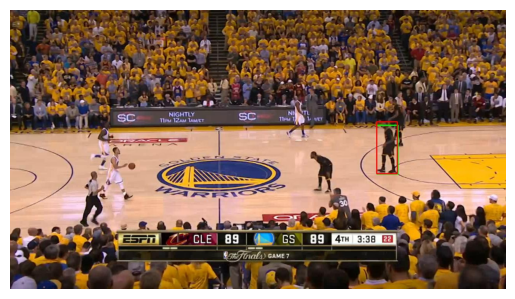

Above image is Showing the bounding box for the second frame of the sequence. RED IS GROUND TRUTH AND GREEN IS PREDICTED
Bounding boxes saved to trackresults_TM_seq1.txt file!
Results saved in data/seq1/results2 folder
Average Success for this Sequence: 0.3135227583362394
Average Euclidean Center distance between ground truth and tracked bounding for this Sequence: 232.2139986566884
Precision at 20px: 0.3800
Precision at 50px: 0.3800
Precision at 100px: 0.4600
Precision at 200px: 0.6467


In [69]:
with open( "data/seq1/nlp.txt", "r") as file:
    object_description = file.readline().strip()

print(f"Object to track: {object_description}")


# Path to images
images_folder = "data/seq1/img/"
image_files = sorted(glob.glob(f"{images_folder}/*.jpg"))

# Define output folder and file
output_dir = "results/2_objectdetection_withassociation/"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "trackresults_OD_seq1.txt")

with open("data/seq1/firsttrack.txt", "r") as file:
    gt_bbox = list(map(int, file.readline().strip().split(",")))  # x, y, w, h
print(f"/Initialized Ground Truth: {gt_bbox}")

prev_bbox = gt_bbox  # Initialize with ground truth
# Read the ground truth bounding boxes from file
ground_truth_file = "data/seq1/groundtruth.txt"
ground_truth_bboxes = []

with open(ground_truth_file, "r") as file:
    for line in file:
        bbox = list(map(int, line.strip().split(",")))  # Assuming x,y,width,height format
        ground_truth_bboxes.append(bbox)

images_files = sorted(glob.glob("data/seq1/img/*.jpg"))
boundingboxresults=[]
ious = []
centers = []

for idx, image_path in enumerate(image_files):
    current_bboxes = detect_objects(image_path, prev_bbox)  # Detect objects in current frame

    # Load original image
    image = cv2.imread(image_path)

    if current_bboxes:
        # for bbox in current_bboxes:
            x, y, w, h = current_bboxes
            print(current_bboxes)

            # Draw bounding box
            cv2.rectangle(image, (int(x), int(y)), (int(x + w), int(y + h)), (0, 255, 0), 2)
            #cv2.putText(image, label, (int(x), int(y) - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

            prev_bbox = current_bboxes  # Update previous bounding box
            
    x_gt, y_gt, w_gt, h_gt = ground_truth_bboxes[idx]
    cv2.rectangle(image, (x_gt, y_gt), (x_gt + w_gt, y_gt + h_gt),(0,0 ,255), thickness)   
    output_path = f"data/seq1/results2/{os.path.basename(image_path)}"
    cv2.imwrite(output_path, image)

    iou = compute_iou(prev_bbox, ground_truth_bboxes[idx]) if idx < len(ground_truth_bboxes) else 0
    #print(f"IOU: {iou}")
    ious.append(iou)

    center = bbox_center(prev_bbox)
    gt_center = bbox_center(ground_truth_bboxes[idx]) if idx < len(ground_truth_bboxes) else None
    if gt_center is not None:
        distance = np.linalg.norm(center - gt_center)
        centers.append(distance)
        #print(f"✅ Precision: {distance}")
    
    print(f"/Saved detection: {output_path}")

#Save the tracking results
with open(output_file, "w") as file:
    for bbox in boundingboxresults:
        file.write(f"{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]}\n")

print(f"/Object detection with association saved in {output_file}")

img = mpimg.imread('data/seq1/results2/00000002.jpg')  # Replace with your image file path
#img_rgb = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.show()

print("Above image is Showing the bounding box for the second frame of the sequence. RED IS GROUND TRUTH AND GREEN IS PREDICTED")

print("Bounding boxes saved to trackresults_TM_seq1.txt file!")
print ("Results saved in data/seq1/results2 folder")
print(f"Average Success for this Sequence: {np.mean(ious)}")
print(f"Average Euclidean Center distance between ground truth and tracked bounding for this Sequence: {np.mean(centers)}")

# Define thresholds
thresholds = [20, 50, 100, 200]

# Compute precision for each threshold
for t in thresholds:
    precision = sum(d < t for d in centers) / len(centers)
    print(f"Precision at {t}px: {precision:.4f}")



Sequence 2

Object to track: girl playing gymnastics
/Initialized Ground Truth: [144, 231, 39, 96]
(142.2532958984375, 232.31886291503906, 31.91754150390625, 91.28916931152344)
/Saved detection: data/seq2/results2/00000001.jpg
(144.88278198242188, 230.39501953125, 36.213897705078125, 92.39230346679688)
/Saved detection: data/seq2/results2/00000002.jpg
(146.65321350097656, 230.79396057128906, 33.581512451171875, 91.80882263183594)
/Saved detection: data/seq2/results2/00000003.jpg
(147.5358428955078, 229.27294921875, 30.885574340820312, 92.961669921875)
/Saved detection: data/seq2/results2/00000004.jpg
(151.02964782714844, 227.55105590820312, 30.266616821289062, 90.377197265625)
/Saved detection: data/seq2/results2/00000005.jpg
(151.39071655273438, 226.63304138183594, 33.829559326171875, 91.96363830566406)
/Saved detection: data/seq2/results2/00000006.jpg
(154.29415893554688, 226.47259521484375, 33.98370361328125, 92.81512451171875)
/Saved detection: data/seq2/results2/00000007.jpg
(157.013168334960

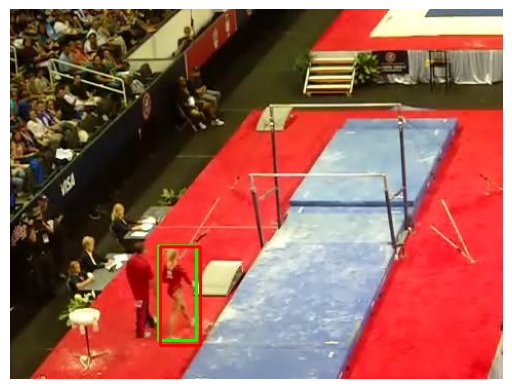

Above image is Showing the bounding box for the second frame of the sequence. RED IS GROUND TRUTH AND GREEN IS PREDICTED
Bounding boxes saved to trackresults_TM_seq2.txt file!
Results saved in data/seq2/results2 folder
Average Success for this Sequence: 0.43416024005414044
Average Euclidean Center distance between ground truth and tracked bounding for this Sequence: 58.3810886839323
Precision at 20px: 0.5467
Precision at 50px: 0.6733
Precision at 100px: 0.6733
Precision at 200px: 1.0000


In [70]:
with open( "data/seq2/nlp.txt", "r") as file:
    object_description = file.readline().strip()

print(f"Object to track: {object_description}")


# Path to images
images_folder = "data/seq2/img/"
image_files = sorted(glob.glob(f"{images_folder}/*.jpg"))

# Define output folder and file
output_dir = "results/2_objectdetection_withassociation/"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "trackresults_OD_seq1.txt")

with open("data/seq2/firsttrack.txt", "r") as file:
    gt_bbox = list(map(int, file.readline().strip().split(",")))  # x, y, w, h
print(f"/Initialized Ground Truth: {gt_bbox}")

prev_bbox = gt_bbox  # Initialize with ground truth
# Read the ground truth bounding boxes from file
ground_truth_file = "data/seq2/groundtruth.txt"
ground_truth_bboxes = []

with open(ground_truth_file, "r") as file:
    for line in file:
        bbox = list(map(int, line.strip().split(",")))  # Assuming x,y,width,height format
        ground_truth_bboxes.append(bbox)

images_files = sorted(glob.glob("data/seq2/img/*.jpg"))
boundingboxresults=[]
ious = []
centers = []

for idx, image_path in enumerate(image_files):
    current_bboxes = detect_objects(image_path, prev_bbox)  # Detect objects in current frame

    # Load original image
    image = cv2.imread(image_path)

    if current_bboxes:
        # for bbox in current_bboxes:
            x, y, w, h = current_bboxes
            print(current_bboxes)

            # Draw bounding box
            cv2.rectangle(image, (int(x), int(y)), (int(x + w), int(y + h)), (0, 255, 0), 2)
            #cv2.putText(image, label, (int(x), int(y) - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

            prev_bbox = current_bboxes  # Update previous bounding box
            
    x_gt, y_gt, w_gt, h_gt = ground_truth_bboxes[idx]
    cv2.rectangle(image, (x_gt, y_gt), (x_gt + w_gt, y_gt + h_gt),(0,0 ,255), thickness)   
    output_path = f"data/seq2/results2/{os.path.basename(image_path)}"
    cv2.imwrite(output_path, image)

    iou = compute_iou(prev_bbox, ground_truth_bboxes[idx]) if idx < len(ground_truth_bboxes) else 0
    #print(f"IOU: {iou}")
    ious.append(iou)

    center = bbox_center(prev_bbox)
    gt_center = bbox_center(ground_truth_bboxes[idx]) if idx < len(ground_truth_bboxes) else None
    if gt_center is not None:
        distance = np.linalg.norm(center - gt_center)
        centers.append(distance)
        #print(f"✅ Precision: {distance}")
    
    print(f"/Saved detection: {output_path}")

#Save the tracking results
with open(output_file, "w") as file:
    for bbox in boundingboxresults:
        file.write(f"{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]}\n")

print(f"/Object detection with association saved in {output_file}")

img = mpimg.imread('data/seq2/results2/00000002.jpg')  # Replace with your image file path
#img_rgb = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.show()

print("Above image is Showing the bounding box for the second frame of the sequence. RED IS GROUND TRUTH AND GREEN IS PREDICTED")

print("Bounding boxes saved to trackresults_TM_seq2.txt file!")
print ("Results saved in data/seq2/results2 folder")
print(f"Average Success for this Sequence: {np.mean(ious)}")
print(f"Average Euclidean Center distance between ground truth and tracked bounding for this Sequence: {np.mean(centers)}")

# Define thresholds
thresholds = [20, 50, 100, 200]

# Compute precision for each threshold
for t in thresholds:
    precision = sum(d < t for d in centers) / len(centers)
    print(f"Precision at {t}px: {precision:.4f}")




Sequence 3

Object to track: boy in black suit dancing
/Initialized Ground Truth: [256, 48, 175, 312]
(262.17181396484375, 48.51693344116211, 108.57614135742188, 303.82016372680664)
/Saved detection: data/seq3/results2/00000001.jpg
(266.6399841308594, 47.74276351928711, 105.6436767578125, 306.6831703186035)
/Saved detection: data/seq3/results2/00000002.jpg
(266.6546630859375, 47.56706619262695, 106.12322998046875, 305.1688346862793)
/Saved detection: data/seq3/results2/00000003.jpg
(269.8534851074219, 48.8468017578125, 106.44418334960938, 309.59588623046875)
/Saved detection: data/seq3/results2/00000004.jpg
(273.8345947265625, 49.89324951171875, 129.68057250976562, 308.778076171875)
/Saved detection: data/seq3/results2/00000005.jpg
(278.7634582519531, 48.55995559692383, 124.98056030273438, 310.0458183288574)
/Saved detection: data/seq3/results2/00000006.jpg
(286.84197998046875, 50.15375900268555, 111.17300415039062, 308.34123611450195)
/Saved detection: data/seq3/results2/00000007.jpg
(286.4625244

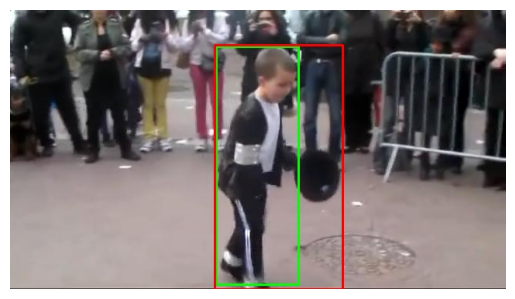

Above image is Showing the bounding box for the second frame of the sequence. RED IS GROUND TRUTH AND GREEN IS PREDICTED
Bounding boxes saved to trackresults_TM_seq3.txt file!
Results saved in data/seq3/results2 folder
Average Success for this Sequence: 0.18245551727039583
Average Euclidean Center distance between ground truth and tracked bounding for this Sequence: 145.22058242673822
Precision at 20px: 0.0733
Precision at 50px: 0.1467
Precision at 100px: 0.2733
Precision at 200px: 0.6933


In [71]:
with open( "data/seq3/nlp.txt", "r") as file:
    object_description = file.readline().strip()

print(f"Object to track: {object_description}")


# Path to images
images_folder = "data/seq3/img/"
image_files = sorted(glob.glob(f"{images_folder}/*.jpg"))

# Define output folder and file
output_dir = "results/2_objectdetection_withassociation/"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "trackresults_OD_seq3.txt")

with open("data/seq3/firsttrack.txt", "r") as file:
    gt_bbox = list(map(int, file.readline().strip().split(",")))  # x, y, w, h
print(f"/Initialized Ground Truth: {gt_bbox}")

prev_bbox = gt_bbox  # Initialize with ground truth
# Read the ground truth bounding boxes from file
ground_truth_file = "data/seq3/groundtruth.txt"
ground_truth_bboxes = []

with open(ground_truth_file, "r") as file:
    for line in file:
        bbox = list(map(int, line.strip().split(",")))  # Assuming x,y,width,height format
        ground_truth_bboxes.append(bbox)

images_files = sorted(glob.glob("data/seq3/img/*.jpg"))
boundingboxresults=[]
ious = []
centers = []

for idx, image_path in enumerate(image_files):
    current_bboxes = detect_objects(image_path, prev_bbox)  # Detect objects in current frame

    # Load original image
    image = cv2.imread(image_path)

    if current_bboxes:
        # for bbox in current_bboxes:
            x, y, w, h = current_bboxes
            print(current_bboxes)

            # Draw bounding box
            cv2.rectangle(image, (int(x), int(y)), (int(x + w), int(y + h)), (0, 255, 0), 2)
            #cv2.putText(image, label, (int(x), int(y) - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

            prev_bbox = current_bboxes  # Update previous bounding box
            
    x_gt, y_gt, w_gt, h_gt = ground_truth_bboxes[idx]
    cv2.rectangle(image, (x_gt, y_gt), (x_gt + w_gt, y_gt + h_gt),(0,0 ,255), thickness)   
    output_path = f"data/seq3/results2/{os.path.basename(image_path)}"
    cv2.imwrite(output_path, image)

    iou = compute_iou(prev_bbox, ground_truth_bboxes[idx]) if idx < len(ground_truth_bboxes) else 0
    #print(f"IOU: {iou}")
    ious.append(iou)

    center = bbox_center(prev_bbox)
    gt_center = bbox_center(ground_truth_bboxes[idx]) if idx < len(ground_truth_bboxes) else None
    if gt_center is not None:
        distance = np.linalg.norm(center - gt_center)
        centers.append(distance)
        #print(f"✅ Precision: {distance}")
    
    print(f"/Saved detection: {output_path}")

#Save the tracking results
with open(output_file, "w") as file:
    for bbox in boundingboxresults:
        file.write(f"{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]}\n")

print(f"/Object detection with association saved in {output_file}")

img = mpimg.imread('data/seq3/results2/00000002.jpg')  # Replace with your image file path
#img_rgb = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.show()

print("Above image is Showing the bounding box for the second frame of the sequence. RED IS GROUND TRUTH AND GREEN IS PREDICTED")

print("Bounding boxes saved to trackresults_TM_seq3.txt file!")
print ("Results saved in data/seq3/results2 folder")
print(f"Average Success for this Sequence: {np.mean(ious)}")
print(f"Average Euclidean Center distance between ground truth and tracked bounding for this Sequence: {np.mean(centers)}")

# Define thresholds
thresholds = [20, 50, 100, 200]

# Compute precision for each threshold
for t in thresholds:
    precision = sum(d < t for d in centers) / len(centers)
    print(f"Precision at {t}px: {precision:.4f}")



Sequence 4

Object to track: woman in red playing volleyball
/Initialized Ground Truth: [686, 426, 58, 171]
(684.2603149414062, 406.7373046875, 59.26055908203125, 182.5218505859375)
/Saved detection: data/seq4/results2/00000001.jpg
(684.0232543945312, 408.1392517089844, 59.48504638671875, 179.85617065429688)
/Saved detection: data/seq4/results2/00000002.jpg
(679.7997436523438, 408.0004577636719, 58.5645751953125, 176.18869018554688)
/Saved detection: data/seq4/results2/00000003.jpg
(676.4954223632812, 412.4492492675781, 59.23883056640625, 173.64028930664062)
/Saved detection: data/seq4/results2/00000004.jpg
(666.132568359375, 423.78082275390625, 60.49017333984375, 141.705078125)
/Saved detection: data/seq4/results2/00000005.jpg
(660.4652099609375, 398.5777282714844, 63.37579345703125, 171.82400512695312)
/Saved detection: data/seq4/results2/00000006.jpg
(660.9932861328125, 398.58428955078125, 63.00146484375, 168.6004638671875)
/Saved detection: data/seq4/results2/00000007.jpg
(659.1709594726562, 3

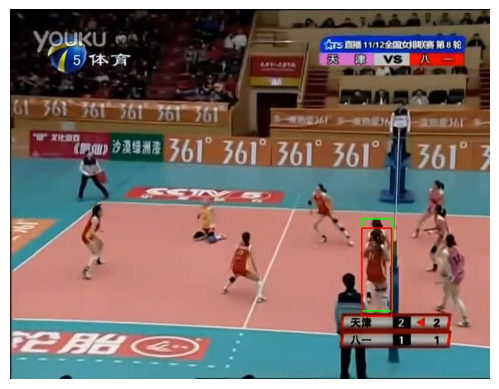

Above image is Showing the bounding box for the second frame of the sequence. RED IS GROUND TRUTH AND GREEN IS PREDICTED
Bounding boxes saved to trackresults_TM_seq4.txt file!
Results saved in data/seq4/results2 folder
Average Success for this Sequence: 0.060302107292960754
Average Euclidean Center distance between ground truth and tracked bounding for this Sequence: 268.5524241478017
Precision at 20px: 0.0533
Precision at 50px: 0.0733
Precision at 100px: 0.1133
Precision at 200px: 0.2400


In [72]:
with open( "data/seq4/nlp.txt", "r") as file:
    object_description = file.readline().strip()

print(f"Object to track: {object_description}")


# Path to images
images_folder = "data/seq4/img/"
image_files = sorted(glob.glob(f"{images_folder}/*.jpg"))

# Define output folder and file
output_dir = "results/2_objectdetection_withassociation/"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "trackresults_OD_seq4.txt")

with open("data/seq4/firsttrack.txt", "r") as file:
    gt_bbox = list(map(int, file.readline().strip().split(",")))  # x, y, w, h
print(f"/Initialized Ground Truth: {gt_bbox}")

prev_bbox = gt_bbox  # Initialize with ground truth
# Read the ground truth bounding boxes from file
ground_truth_file = "data/seq4/groundtruth.txt"
ground_truth_bboxes = []

with open(ground_truth_file, "r") as file:
    for line in file:
        bbox = list(map(int, line.strip().split(",")))  # Assuming x,y,width,height format
        ground_truth_bboxes.append(bbox)

images_files = sorted(glob.glob("data/seq4/img/*.jpg"))
boundingboxresults=[]
ious = []
centers = []

for idx, image_path in enumerate(image_files):
    current_bboxes = detect_objects(image_path, prev_bbox)  # Detect objects in current frame

    # Load original image
    image = cv2.imread(image_path)

    if current_bboxes:
        # for bbox in current_bboxes:
            x, y, w, h = current_bboxes
            print(current_bboxes)

            # Draw bounding box
            cv2.rectangle(image, (int(x), int(y)), (int(x + w), int(y + h)), (0, 255, 0), 2)
            #cv2.putText(image, label, (int(x), int(y) - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

            prev_bbox = current_bboxes  # Update previous bounding box
            
    x_gt, y_gt, w_gt, h_gt = ground_truth_bboxes[idx]
    cv2.rectangle(image, (x_gt, y_gt), (x_gt + w_gt, y_gt + h_gt),(0,0 ,255), thickness)   
    output_path = f"data/seq4/results2/{os.path.basename(image_path)}"
    cv2.imwrite(output_path, image)

    iou = compute_iou(prev_bbox, ground_truth_bboxes[idx]) if idx < len(ground_truth_bboxes) else 0
    #print(f"IOU: {iou}")
    ious.append(iou)

    center = bbox_center(prev_bbox)
    gt_center = bbox_center(ground_truth_bboxes[idx]) if idx < len(ground_truth_bboxes) else None
    if gt_center is not None:
        distance = np.linalg.norm(center - gt_center)
        centers.append(distance)
        #print(f"✅ Precision: {distance}")
    
    print(f"/Saved detection: {output_path}")

#Save the tracking results
with open(output_file, "w") as file:
    for bbox in boundingboxresults:
        file.write(f"{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]}\n")

print(f"/Object detection with association saved in {output_file}")

img = mpimg.imread('data/seq4/results2/00000002.jpg')  # Replace with your image file path
#img_rgb = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.show()

print("Above image is Showing the bounding box for the second frame of the sequence. RED IS GROUND TRUTH AND GREEN IS PREDICTED")

print("Bounding boxes saved to trackresults_TM_seq4.txt file!")
print ("Results saved in data/seq4/results2 folder")
print(f"Average Success for this Sequence: {np.mean(ious)}")
print(f"Average Euclidean Center distance between ground truth and tracked bounding for this Sequence: {np.mean(centers)}")

# Define thresholds
thresholds = [20, 50, 100, 200]

# Compute precision for each threshold
for t in thresholds:
    precision = sum(d < t for d in centers) / len(centers)
    print(f"Precision at {t}px: {precision:.4f}")



Sequence 5

Object to track: white cat moving around a toy tiger on the blanket
/Initialized Ground Truth: [137, 320, 233, 191]
(98.41472625732422, 318.0715637207031, 276.39456939697266, 194.64413452148438)
/Saved detection: data/seq5/results2/00000001.jpg
(94.9496841430664, 318.15728759765625, 278.59810638427734, 201.3758544921875)
/Saved detection: data/seq5/results2/00000002.jpg
(92.69168853759766, 319.4199523925781, 274.2234420776367, 203.83309936523438)
/Saved detection: data/seq5/results2/00000003.jpg
(91.37164306640625, 320.1253662109375, 271.1069641113281, 199.25103759765625)
/Saved detection: data/seq5/results2/00000004.jpg
(89.4221420288086, 318.3138732910156, 268.17057037353516, 203.83303833007812)
/Saved detection: data/seq5/results2/00000005.jpg
(87.01776123046875, 316.76300048828125, 263.88677978515625, 207.2840576171875)
/Saved detection: data/seq5/results2/00000006.jpg
(85.85931396484375, 321.865966796875, 261.380615234375, 205.92584228515625)
/Saved detection: data/seq5/results2/0

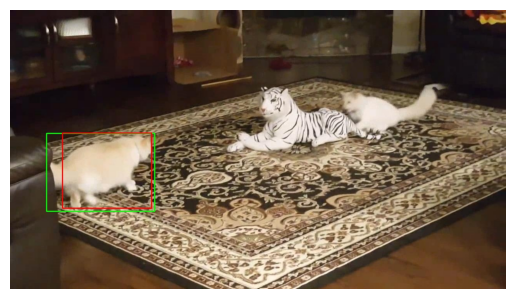

Above image is Showing the bounding box for the second frame of the sequence. RED IS GROUND TRUTH AND GREEN IS PREDICTED
Bounding boxes saved to trackresults_TM_seq5.txt file!
Results saved in data/seq5/results2 folder
Average Success for this Sequence: 0.6699898450902528
Average Euclidean Center distance between ground truth and tracked bounding for this Sequence: 125.75954126157012
Precision at 20px: 0.3467
Precision at 50px: 0.8800
Precision at 100px: 0.8800
Precision at 200px: 0.8800


In [73]:
with open( "data/seq5/nlp.txt", "r") as file:
    object_description = file.readline().strip()

print(f"Object to track: {object_description}")


# Path to images
images_folder = "data/seq5/img/"
image_files = sorted(glob.glob(f"{images_folder}/*.jpg"))

# Define output folder and file
output_dir = "results/2_objectdetection_withassociation/"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "trackresults_OD_seq5.txt")

with open("data/seq5/firsttrack.txt", "r") as file:
    gt_bbox = list(map(int, file.readline().strip().split(",")))  # x, y, w, h
print(f"/Initialized Ground Truth: {gt_bbox}")

prev_bbox = gt_bbox  # Initialize with ground truth
# Read the ground truth bounding boxes from file
ground_truth_file = "data/seq5/groundtruth.txt"
ground_truth_bboxes = []

with open(ground_truth_file, "r") as file:
    for line in file:
        bbox = list(map(int, line.strip().split(",")))  # Assuming x,y,width,height format
        ground_truth_bboxes.append(bbox)

images_files = sorted(glob.glob("data/seq5/img/*.jpg"))
boundingboxresults=[]
ious = []
centers = []

for idx, image_path in enumerate(image_files):
    current_bboxes = detect_objects(image_path, prev_bbox)  # Detect objects in current frame

    # Load original image
    image = cv2.imread(image_path)

    if current_bboxes:
        # for bbox in current_bboxes:
            x, y, w, h = current_bboxes
            print(current_bboxes)

            # Draw bounding box
            cv2.rectangle(image, (int(x), int(y)), (int(x + w), int(y + h)), (0, 255, 0), 2)
            #cv2.putText(image, label, (int(x), int(y) - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

            prev_bbox = current_bboxes  # Update previous bounding box
            
    x_gt, y_gt, w_gt, h_gt = ground_truth_bboxes[idx]
    cv2.rectangle(image, (x_gt, y_gt), (x_gt + w_gt, y_gt + h_gt),(0,0 ,255), thickness)   
    output_path = f"data/seq5/results2/{os.path.basename(image_path)}"
    cv2.imwrite(output_path, image)

    iou = compute_iou(prev_bbox, ground_truth_bboxes[idx]) if idx < len(ground_truth_bboxes) else 0
    #print(f"IOU: {iou}")
    ious.append(iou)

    center = bbox_center(prev_bbox)
    gt_center = bbox_center(ground_truth_bboxes[idx]) if idx < len(ground_truth_bboxes) else None
    if gt_center is not None:
        distance = np.linalg.norm(center - gt_center)
        centers.append(distance)
        #print(f"✅ Precision: {distance}")
    
    print(f"/Saved detection: {output_path}")

#Save the tracking results
with open(output_file, "w") as file:
    for bbox in boundingboxresults:
        file.write(f"{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]}\n")

print(f"/Object detection with association saved in {output_file}")

img = mpimg.imread('data/seq5/results2/00000002.jpg')  # Replace with your image file path
#img_rgb = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.show()

print("Above image is Showing the bounding box for the second frame of the sequence. RED IS GROUND TRUTH AND GREEN IS PREDICTED")

print("Bounding boxes saved to trackresults_TM_seq5.txt file!")
print ("Results saved in data/seq5/results2 folder")
print(f"Average Success for this Sequence: {np.mean(ious)}")
print(f"Average Euclidean Center distance between ground truth and tracked bounding for this Sequence: {np.mean(centers)}")

# Define thresholds
thresholds = [20, 50, 100, 200]

# Compute precision for each threshold
for t in thresholds:
    precision = sum(d < t for d in centers) / len(centers)
    print(f"Precision at {t}px: {precision:.4f}")



Evaluate the performance of the Single object tracking algorithm for both **Template Matching** and **Detection Algorithm with Association**. Using the **Success** and **Precision** metrics. 

$$
Success = \frac{BB_{tr} \cap BB_{gt}}{BB_{tr} \cup BB_{gt}} ;    
Precision = || C_{tr} - C_{gt} ||_2
$$

In [74]:
##The above task of Success and Precision has been done for each sequence in Template matching Detection and Object Detection with Association. 
#Run the code above to see the results for each sequence.
#Average score for each algorithm is shown in the report.

## Task1.3 Improved Method

### YOLOv11 with Extended Kalman Filter and IOU

In [75]:
!pip install ultralytics
!pip install filterpy

In [76]:
from ultralytics import YOLO
from filterpy.kalman import ExtendedKalmanFilter
from filterpy.common import Q_discrete_white_noise

yolo_model = YOLO("yolo11x.pt")

def detect_objects(image_path, threshold=0.2):
    
    # Run YOLOv8 on the image
    results = yolo_model(image_path)
    #print(f"Model file path: {yolo_model.ckpt_path}")

    # Extract bounding boxes
    detections = []
    for result in results:
        for box in result.boxes:
            x_min, y_min, x_max, y_max = box.xyxy[0].tolist()  # YOLO returns (xmin, ymin, xmax, ymax)
            conf = box.conf[0].item()
            label = int(box.cls[0].item())

            if conf > threshold:  # Apply confidence threshold
                w = x_max - x_min
                h = y_max - y_min
                detections.append(([x_min, y_min, w, h], conf, label, None))  # Format for DeepSORT

    return detections  # Return bounding boxes for tracking
def HJacobian(x):
    """Returns the Jacobian matrix H (which is just an identity matrix in this case)."""
    return np.eye(6)

def Hx(x):
    """Returns the predicted measurement from the state."""
    return x  # Since we're measuring x, y, w, h directly

Initialized Ground Truth: [951, 287, 54, 134]

image 1/1 /home/anurag/Downloads/Homework1_Perception_v2/task1_tracking/data/seq1/img/00000001.jpg: 384x640 6 persons, 1 sports ball, 16.8ms
Speed: 0.9ms preprocess, 16.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Saved tracked frame: data/seq1/results3/00000001.jpg

image 1/1 /home/anurag/Downloads/Homework1_Perception_v2/task1_tracking/data/seq1/img/00000002.jpg: 384x640 6 persons, 16.6ms
Speed: 0.9ms preprocess, 16.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)
Saved tracked frame: data/seq1/results3/00000002.jpg

image 1/1 /home/anurag/Downloads/Homework1_Perception_v2/task1_tracking/data/seq1/img/00000003.jpg: 384x640 6 persons, 16.5ms
Speed: 0.9ms preprocess, 16.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Saved tracked frame: data/seq1/results3/00000003.jpg

image 1/1 /home/anurag/Downloads/Homework1_Perception_v2/task1_tracking/data/seq1/img/00000004.jpg: 384x640

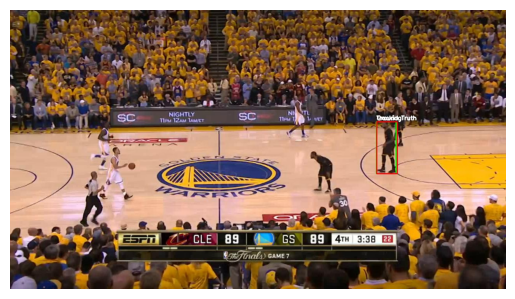

Above image is Showing the bounding box for the second frame of the sequence. RED IS GROUND TRUTH AND GREEN IS PREDICTED
Bounding boxes saved to trackresults_TM_seq1.txt file!
Results saved in data/seq1/results3 folder
Average Success for this Sequence: 0.8768326395234594
Average Euclidean Center distance between ground truth and tracked bounding for this Sequence: 5.530068020515176
Precision at 20px: 0.9533
Precision at 50px: 1.0000
Precision at 100px: 1.0000
Precision at 200px: 1.0000


In [77]:
# Path to images
images_folder = "data/seq1/img/"
image_files = sorted(glob.glob(f"{images_folder}/*.jpg"))

# Define output folder and file
output_dir = "results/3_improved/"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "trackresults_improved_seq1.txt")


with open("data/seq1/firsttrack.txt", "r") as file:
    gt_bbox = list(map(int, file.readline().strip().split(",")))  # x, y, w, h
print(f"Initialized Ground Truth: {gt_bbox}")

ground_truth_file = "data/seq1/groundtruth.txt"

with open(ground_truth_file, "r") as file:
    gt_bboxes = [list(map(int, line.strip().split(","))) for line in file.readlines()]



prev_id = None  # Store the object ID of the target object
prev_bbox = gt_bbox 

detection_lost = False

# EKF State [x, y, w, h, vx, vy]
state = np.array([gt_bbox[0], gt_bbox[1], gt_bbox[2], gt_bbox[3], 0, 0])  # Initial position and zero velocity
P = np.eye(6) * 500  # Initial covariance

# State Transition Matrix (Constant velocity model)
dt = 1  # Time step
F = np.array([
    [1, 0, 0, 0, dt, 0],  # x = x + vx * dt
    [0, 1, 0, 0, 0, dt],  # y = y + vy * dt
    [0, 0, 1, 0, 0, 0],   # width (constant)
    [0, 0, 0, 1, 0, 0],   # height (constant)
    [0, 0, 0, 0, 1, 0],   # velocity x
    [0, 0, 0, 0, 0, 1]    # velocity y
])

# Process noise covariance matrix (Assuming noise in position and velocity)
q_var = 2  # Variance of noise
Q = np.array([
    [q_var, 0, 0, 0, 0, 0],
    [0, q_var, 0, 0, 0, 0],
    [0, 0, q_var, 0, 0, 0],
    [0, 0, 0, q_var, 0, 0],
    [0, 0, 0, 0, q_var, 0],
    [0, 0, 0, 0, 0, q_var]
])

H = np.eye(6)  # Measurement function
R = np.eye(6) * 10  # Measurement noise

kf = ExtendedKalmanFilter(dim_x=6, dim_z=6)
kf.x = state
kf.F = F
kf.P = P
kf.Q = Q
kf.H = H
kf.R = R

boundingboxresults = []
ious = []
centers = []
for idx, image_path in enumerate(image_files):
    # Detect objects
    detections = detect_objects(image_path, threshold=0.2)

    # Load image
    image = cv2.imread(image_path)

    # Predict next state using EKF
    kf.predict()

    best_bbox = None

    if detections:
        if prev_bbox is not None:
            # Find best matching bounding box
            best_bbox = max(detections, key=lambda bbox: compute_iou(bbox[0], prev_bbox), default=None)

            if best_bbox and compute_iou(best_bbox[0], prev_bbox) > 0.3:
                detection_lost = False  # Detection is back
                prev_bbox = best_bbox[0]

                # EKF Update
                measurement = np.array([prev_bbox[0], prev_bbox[1], prev_bbox[2], prev_bbox[3], 0, 0])  # No velocity info
                kf.update(measurement, HJacobian, Hx)
            else:
                best_bbox = None

    if not best_bbox:
        detection_lost = True
        prev_bbox = kf.x[:4]  # Use predicted state when detection is lost

    # Draw bounding box
    x, y, w, h = map(int, prev_bbox)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(image, "Tracking" if not detection_lost else "Predicting", (x, y - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    
    boundingboxresults.append((x, y, w, h))

        # Draw ground truth bounding box (red)
    if idx < len(gt_bboxes):
        gt_x, gt_y, gt_w, gt_h = gt_bboxes[idx]
        cv2.rectangle(image, (gt_x, gt_y), (gt_x + gt_w, gt_y + gt_h), (0, 0, 255), 2)
        cv2.putText(image, "Ground Truth", (gt_x, gt_y - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    
    #Compute the IOU between the predicted and ground truth bounding boxes, and add it to a list so i can average it later
    
    iou = compute_iou(prev_bbox, gt_bboxes[idx]) if idx < len(gt_bboxes) else 0
    #print(f"IOU: {iou}")
    ious.append(iou)

    center = bbox_center(prev_bbox)
    gt_center = bbox_center(gt_bboxes[idx]) if idx < len(gt_bboxes) else None
    if gt_center is not None:
        distance = np.linalg.norm(center - gt_center)
        centers.append(distance)
        #print(f" Precision: {distance}")
       

    
    # Save the tracked frame
    output_path = f"data/seq1/results3/{os.path.basename(image_path)}"
    cv2.imwrite(output_path, image)

    

    print(f"Saved tracked frame: {output_path}")

#Save the tracking results
with open(output_file, "w") as file:
    for bbox in boundingboxresults:
        file.write(f"{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]}\n")

print(f"Object detection with association saved in {output_file}")


img = mpimg.imread('data/seq1/results3/00000002.jpg')  # Replace with your image file path
#img_rgb = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.show()

print("Above image is Showing the bounding box for the second frame of the sequence. RED IS GROUND TRUTH AND GREEN IS PREDICTED")

print("Bounding boxes saved to trackresults_TM_seq1.txt file!")
print ("Results saved in data/seq1/results3 folder")
print(f"Average Success for this Sequence: {np.mean(ious)}")
print(f"Average Euclidean Center distance between ground truth and tracked bounding for this Sequence: {np.mean(centers)}")

# Define thresholds
thresholds = [20, 50, 100, 200]

# Compute precision for each threshold
for t in thresholds:
    precision = sum(d < t for d in centers) / len(centers)
    print(f"Precision at {t}px: {precision:.4f}")


##TO DETECT ALL OBJECTS IN THE IMAGE

# for image_path in image_files:
#     # Detect objects
#     detections = detect_objects(image_path, threshold=0.2)

#     # Load original image
#     image = cv2.imread(image_path)

#     # Find best match using IoU
#     if detections:
#         if prev_bbox:
#             best_bbox = max(detections, key=lambda bbox: compute_iou(bbox[0], prev_bbox), default=None)
#             if best_bbox and compute_iou(best_bbox[0], prev_bbox) > 0.3:
#                 prev_bbox = best_bbox[0]  # Update tracking
#         else:
#             best_bbox = detections[0]  # Pick first detected object if no previous bbox
#             prev_bbox = best_bbox[0]

#         # Draw bounding box
#         x, y, w, h = prev_bbox
#         cv2.rectangle(image, (int(x), int(y)), (int(x + w), int(y + h)), (0, 255, 0), 2)
#         cv2.putText(image, "Tracking", (int(x), int(y) - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    
#         # Save the tracked frame
#     output_path = f"/home/anurag/Downloads/Homework1_Perception_v2/task1_tracking/data/seq1/results3/{os.path.basename(image_path)}"
#     cv2.imwrite(output_path, image)

#     print(f"✅ Saved tracked frame: {output_path}")






Sequence 2

Initialized Ground Truth: [144, 231, 39, 96]



image 1/1 /home/anurag/Downloads/Homework1_Perception_v2/task1_tracking/data/seq2/img/00000001.jpg: 480x640 3 persons, 1 train, 20.4ms
Speed: 1.3ms preprocess, 20.4ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)
Saved tracked frame: data/seq2/results3/00000001.jpg

image 1/1 /home/anurag/Downloads/Homework1_Perception_v2/task1_tracking/data/seq2/img/00000002.jpg: 480x640 3 persons, 1 train, 19.9ms
Speed: 1.2ms preprocess, 19.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)
Saved tracked frame: data/seq2/results3/00000002.jpg

image 1/1 /home/anurag/Downloads/Homework1_Perception_v2/task1_tracking/data/seq2/img/00000003.jpg: 480x640 3 persons, 1 train, 19.8ms
Speed: 1.0ms preprocess, 19.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
Saved tracked frame: data/seq2/results3/00000003.jpg

image 1/1 /home/anurag/Downloads/Homework1_Perception_v2/task1_tracking/data/seq2/img/00000004.jpg: 480x640 3 persons, 1 train, 19.9ms
Speed: 

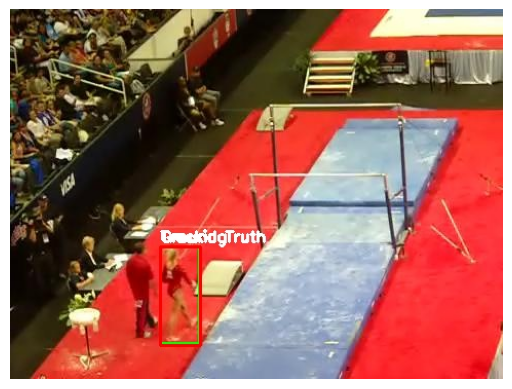

Above image is Showing the bounding box for the second frame of the sequence. RED IS GROUND TRUTH AND GREEN IS PREDICTED
Bounding boxes saved to trackresults_TM_seq2.txt file!
Results saved in data/seq2/results3 folder
Average Success for this Sequence: 0.718391530055982
Average Euclidean Center distance between ground truth and tracked bounding for this Sequence: 9.533474594258472
Precision at 20px: 0.7933
Precision at 50px: 1.0000
Precision at 100px: 1.0000
Precision at 200px: 1.0000


In [78]:
# Path to images
images_folder = "data/seq2/img/"
image_files = sorted(glob.glob(f"{images_folder}/*.jpg"))

# Define output folder and file
output_dir = "results/3_improved/"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "trackresults_improved_seq2.txt")


with open("data/seq2/firsttrack.txt", "r") as file:
    gt_bbox = list(map(int, file.readline().strip().split(",")))  # x, y, w, h
print(f"Initialized Ground Truth: {gt_bbox}")

ground_truth_file = "data/seq2/groundtruth.txt"

with open(ground_truth_file, "r") as file:
    gt_bboxes = [list(map(int, line.strip().split(","))) for line in file.readlines()]



prev_id = None  # Store the object ID of the target object
prev_bbox = gt_bbox 

detection_lost = False

# EKF State [x, y, w, h, vx, vy]
state = np.array([gt_bbox[0], gt_bbox[1], gt_bbox[2], gt_bbox[3], 0, 0])  # Initial position and zero velocity
P = np.eye(6) * 500  # Initial covariance

# State Transition Matrix (Constant velocity model)
dt = 1  # Time step
F = np.array([
    [1, 0, 0, 0, dt, 0],  # x = x + vx * dt
    [0, 1, 0, 0, 0, dt],  # y = y + vy * dt
    [0, 0, 1, 0, 0, 0],   # width (constant)
    [0, 0, 0, 1, 0, 0],   # height (constant)
    [0, 0, 0, 0, 1, 0],   # velocity x
    [0, 0, 0, 0, 0, 1]    # velocity y
])

# Process noise covariance matrix (Assuming noise in position and velocity)
q_var = 2  # Variance of noise
Q = np.array([
    [q_var, 0, 0, 0, 0, 0],
    [0, q_var, 0, 0, 0, 0],
    [0, 0, q_var, 0, 0, 0],
    [0, 0, 0, q_var, 0, 0],
    [0, 0, 0, 0, q_var, 0],
    [0, 0, 0, 0, 0, q_var]
])

H = np.eye(6)  # Measurement function
R = np.eye(6) * 10  # Measurement noise

kf = ExtendedKalmanFilter(dim_x=6, dim_z=6)
kf.x = state
kf.F = F
kf.P = P
kf.Q = Q
kf.H = H
kf.R = R

boundingboxresults = []
ious = []
centers = []
for idx, image_path in enumerate(image_files):
    # Detect objects
    detections = detect_objects(image_path, threshold=0.2)

    # Load image
    image = cv2.imread(image_path)

    # Predict next state using EKF
    kf.predict()

    best_bbox = None

    if detections:
        if prev_bbox is not None:
            # Find best matching bounding box
            best_bbox = max(detections, key=lambda bbox: compute_iou(bbox[0], prev_bbox), default=None)

            if best_bbox and compute_iou(best_bbox[0], prev_bbox) > 0.3:
                detection_lost = False  # Detection is back
                prev_bbox = best_bbox[0]

                # EKF Update
                measurement = np.array([prev_bbox[0], prev_bbox[1], prev_bbox[2], prev_bbox[3], 0, 0])  # No velocity info
                kf.update(measurement, HJacobian, Hx)
            else:
                best_bbox = None

    if not best_bbox:
        detection_lost = True
        prev_bbox = kf.x[:4]  # Use predicted state when detection is lost

    # Draw bounding box
    x, y, w, h = map(int, prev_bbox)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(image, "Tracking" if not detection_lost else "Predicting", (x, y - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    
    boundingboxresults.append((x, y, w, h))

        # Draw ground truth bounding box (red)
    if idx < len(gt_bboxes):
        gt_x, gt_y, gt_w, gt_h = gt_bboxes[idx]
        cv2.rectangle(image, (gt_x, gt_y), (gt_x + gt_w, gt_y + gt_h), (0, 0, 255), 2)
        cv2.putText(image, "Ground Truth", (gt_x, gt_y - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    
    #Compute the IOU between the predicted and ground truth bounding boxes, and add it to a list so i can average it later
    
    iou = compute_iou(prev_bbox, gt_bboxes[idx]) if idx < len(gt_bboxes) else 0
    #print(f"IOU: {iou}")
    ious.append(iou)

    center = bbox_center(prev_bbox)
    gt_center = bbox_center(gt_bboxes[idx]) if idx < len(gt_bboxes) else None
    if gt_center is not None:
        distance = np.linalg.norm(center - gt_center)
        centers.append(distance)
        #print(f" Precision: {distance}")
       

    
    # Save the tracked frame
    output_path = f"data/seq2/results3/{os.path.basename(image_path)}"
    cv2.imwrite(output_path, image)

    

    print(f"Saved tracked frame: {output_path}")

#Save the tracking results
with open(output_file, "w") as file:
    for bbox in boundingboxresults:
        file.write(f"{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]}\n")

print(f"Object detection with association saved in {output_file}")


img = mpimg.imread('data/seq2/results3/00000002.jpg')  # Replace with your image file path
#img_rgb = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.show()

print("Above image is Showing the bounding box for the second frame of the sequence. RED IS GROUND TRUTH AND GREEN IS PREDICTED")

print("Bounding boxes saved to trackresults_TM_seq2.txt file!")
print ("Results saved in data/seq2/results3 folder")
print(f"Average Success for this Sequence: {np.mean(ious)}")
print(f"Average Euclidean Center distance between ground truth and tracked bounding for this Sequence: {np.mean(centers)}")

# Define thresholds
thresholds = [20, 50, 100, 200]

# Compute precision for each threshold
for t in thresholds:
    precision = sum(d < t for d in centers) / len(centers)
    print(f"Precision at {t}px: {precision:.4f}")


Sequence 3

Initialized Ground Truth: [256, 48, 175, 312]

image 1/1 /home/anurag/Downloads/Homework1_Perception_v2/task1_tracking/data/seq3/img/00000001.jpg: 384x640 9 persons, 1 handbag, 1 sports ball, 15.9ms
Speed: 0.8ms preprocess, 15.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)
Saved tracked frame: data/seq3/results3/00000001.jpg

image 1/1 /home/anurag/Downloads/Homework1_Perception_v2/task1_tracking/data/seq3/img/00000002.jpg: 384x640 9 persons, 15.4ms
Speed: 0.7ms preprocess, 15.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)
Saved tracked frame: data/seq3/results3/00000002.jpg

image 1/1 /home/anurag/Downloads/Homework1_Perception_v2/task1_tracking/data/seq3/img/00000003.jpg: 384x640 10 persons, 15.4ms
Speed: 0.7ms preprocess, 15.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)
Saved tracked frame: data/seq3/results3/00000003.jpg

image 1/1 /home/anurag/Downloads/Homework1_Perception_v2/task1_tracking/data/seq3/img/00000004.

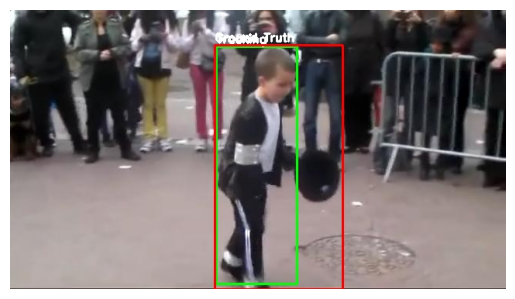

Above image is Showing the bounding box for the second frame of the sequence. RED IS GROUND TRUTH AND GREEN IS PREDICTED
Bounding boxes saved to trackresults_TM_seq3.txt file!
Results saved in data/seq3/results3 folder
Average Success for this Sequence: 0.669333333031837
Average Euclidean Center distance between ground truth and tracked bounding for this Sequence: 48.295137197632975
Precision at 20px: 0.3200
Precision at 50px: 0.4467
Precision at 100px: 1.0000
Precision at 200px: 1.0000


In [79]:
# Path to images
images_folder = "data/seq3/img/"
image_files = sorted(glob.glob(f"{images_folder}/*.jpg"))

# Define output folder and file
output_dir = "results/3_improved/"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "trackresults_improved_seq3.txt")


with open("data/seq3/firsttrack.txt", "r") as file:
    gt_bbox = list(map(int, file.readline().strip().split(",")))  # x, y, w, h
print(f"Initialized Ground Truth: {gt_bbox}")

ground_truth_file = "data/seq3/groundtruth.txt"

with open(ground_truth_file, "r") as file:
    gt_bboxes = [list(map(int, line.strip().split(","))) for line in file.readlines()]



prev_id = None  # Store the object ID of the target object
prev_bbox = gt_bbox 

detection_lost = False

# EKF State [x, y, w, h, vx, vy]
state = np.array([gt_bbox[0], gt_bbox[1], gt_bbox[2], gt_bbox[3], 0, 0])  # Initial position and zero velocity
P = np.eye(6) * 500  # Initial covariance

# State Transition Matrix (Constant velocity model)
dt = 1  # Time step
F = np.array([
    [1, 0, 0, 0, dt, 0],  # x = x + vx * dt
    [0, 1, 0, 0, 0, dt],  # y = y + vy * dt
    [0, 0, 1, 0, 0, 0],   # width (constant)
    [0, 0, 0, 1, 0, 0],   # height (constant)
    [0, 0, 0, 0, 1, 0],   # velocity x
    [0, 0, 0, 0, 0, 1]    # velocity y
])

# Process noise covariance matrix (Assuming noise in position and velocity)
q_var = 2  # Variance of noise
Q = np.array([
    [q_var, 0, 0, 0, 0, 0],
    [0, q_var, 0, 0, 0, 0],
    [0, 0, q_var, 0, 0, 0],
    [0, 0, 0, q_var, 0, 0],
    [0, 0, 0, 0, q_var, 0],
    [0, 0, 0, 0, 0, q_var]
])

H = np.eye(6)  # Measurement function
R = np.eye(6) * 10  # Measurement noise

kf = ExtendedKalmanFilter(dim_x=6, dim_z=6)
kf.x = state
kf.F = F
kf.P = P
kf.Q = Q
kf.H = H
kf.R = R

boundingboxresults = []
ious = []
centers = []
for idx, image_path in enumerate(image_files):
    # Detect objects
    detections = detect_objects(image_path, threshold=0.2)

    # Load image
    image = cv2.imread(image_path)

    # Predict next state using EKF
    kf.predict()

    best_bbox = None

    if detections:
        if prev_bbox is not None:
            # Find best matching bounding box
            best_bbox = max(detections, key=lambda bbox: compute_iou(bbox[0], prev_bbox), default=None)

            if best_bbox and compute_iou(best_bbox[0], prev_bbox) > 0.3:
                detection_lost = False  # Detection is back
                prev_bbox = best_bbox[0]

                # EKF Update
                measurement = np.array([prev_bbox[0], prev_bbox[1], prev_bbox[2], prev_bbox[3], 0, 0])  # No velocity info
                kf.update(measurement, HJacobian, Hx)
            else:
                best_bbox = None

    if not best_bbox:
        detection_lost = True
        prev_bbox = kf.x[:4]  # Use predicted state when detection is lost

    # Draw bounding box
    x, y, w, h = map(int, prev_bbox)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(image, "Tracking" if not detection_lost else "Predicting", (x, y - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    
    boundingboxresults.append((x, y, w, h))

        # Draw ground truth bounding box (red)
    if idx < len(gt_bboxes):
        gt_x, gt_y, gt_w, gt_h = gt_bboxes[idx]
        cv2.rectangle(image, (gt_x, gt_y), (gt_x + gt_w, gt_y + gt_h), (0, 0, 255), 2)
        cv2.putText(image, "Ground Truth", (gt_x, gt_y - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    
    #Compute the IOU between the predicted and ground truth bounding boxes, and add it to a list so i can average it later
    
    iou = compute_iou(prev_bbox, gt_bboxes[idx]) if idx < len(gt_bboxes) else 0
    #print(f"IOU: {iou}")
    ious.append(iou)

    center = bbox_center(prev_bbox)
    gt_center = bbox_center(gt_bboxes[idx]) if idx < len(gt_bboxes) else None
    if gt_center is not None:
        distance = np.linalg.norm(center - gt_center)
        centers.append(distance)
        #print(f" Precision: {distance}")
       

    
    # Save the tracked frame
    output_path = f"data/seq3/results3/{os.path.basename(image_path)}"
    cv2.imwrite(output_path, image)

    

    print(f"Saved tracked frame: {output_path}")

#Save the tracking results
with open(output_file, "w") as file:
    for bbox in boundingboxresults:
        file.write(f"{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]}\n")

print(f"Object detection with association saved in {output_file}")


img = mpimg.imread('data/seq3/results3/00000002.jpg')  # Replace with your image file path
#img_rgb = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.show()

print("Above image is Showing the bounding box for the second frame of the sequence. RED IS GROUND TRUTH AND GREEN IS PREDICTED")

print("Bounding boxes saved to trackresults_TM_seq3.txt file!")
print ("Results saved in data/seq3/results3 folder")
print(f"Average Success for this Sequence: {np.mean(ious)}")
print(f"Average Euclidean Center distance between ground truth and tracked bounding for this Sequence: {np.mean(centers)}")

# Define thresholds
thresholds = [20, 50, 100, 200]

# Compute precision for each threshold
for t in thresholds:
    precision = sum(d < t for d in centers) / len(centers)
    print(f"Precision at {t}px: {precision:.4f}")


Sequence 4

Initialized Ground Truth: [686, 426, 58, 171]

image 1/1 /home/anurag/Downloads/Homework1_Perception_v2/task1_tracking/data/seq4/img/00000001.jpg: 512x640 11 persons, 1 tennis racket, 21.0ms
Speed: 1.5ms preprocess, 21.0ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)
Saved tracked frame: data/seq4/results3/00000001.jpg

image 1/1 /home/anurag/Downloads/Homework1_Perception_v2/task1_tracking/data/seq4/img/00000002.jpg: 512x640 11 persons, 1 tennis racket, 20.5ms
Speed: 1.4ms preprocess, 20.5ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)
Saved tracked frame: data/seq4/results3/00000002.jpg

image 1/1 /home/anurag/Downloads/Homework1_Perception_v2/task1_tracking/data/seq4/img/00000003.jpg: 512x640 11 persons, 20.5ms
Speed: 1.4ms preprocess, 20.5ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)
Saved tracked frame: data/seq4/results3/00000003.jpg

image 1/1 /home/anurag/Downloads/Homework1_Perception_v2/task1_tracking/data/seq4/img

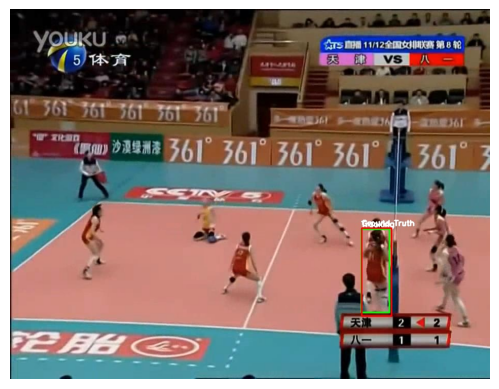

Above image is Showing the bounding box for the second frame of the sequence. RED IS GROUND TRUTH AND GREEN IS PREDICTED
Bounding boxes saved to trackresults_TM_seq4.txt file!
Results saved in data/seq4/results3 folder
Average Success for this Sequence: 0.09075594367822516
Average Euclidean Center distance between ground truth and tracked bounding for this Sequence: 163.7368201088375
Precision at 20px: 0.0667
Precision at 50px: 0.0733
Precision at 100px: 0.3600
Precision at 200px: 0.6200


In [80]:
# Path to images
images_folder = "data/seq4/img/"
image_files = sorted(glob.glob(f"{images_folder}/*.jpg"))

# Define output folder and file
output_dir = "results/3_improved/"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "trackresults_improved_seq4.txt")


with open("data/seq4/firsttrack.txt", "r") as file:
    gt_bbox = list(map(int, file.readline().strip().split(",")))  # x, y, w, h
print(f"Initialized Ground Truth: {gt_bbox}")

ground_truth_file = "data/seq4/groundtruth.txt"

with open(ground_truth_file, "r") as file:
    gt_bboxes = [list(map(int, line.strip().split(","))) for line in file.readlines()]



prev_id = None  # Store the object ID of the target object
prev_bbox = gt_bbox 

detection_lost = False

# EKF State [x, y, w, h, vx, vy]
state = np.array([gt_bbox[0], gt_bbox[1], gt_bbox[2], gt_bbox[3], 0, 0])  # Initial position and zero velocity
P = np.eye(6) * 500  # Initial covariance

# State Transition Matrix (Constant velocity model)
dt = 1  # Time step
F = np.array([
    [1, 0, 0, 0, dt, 0],  # x = x + vx * dt
    [0, 1, 0, 0, 0, dt],  # y = y + vy * dt
    [0, 0, 1, 0, 0, 0],   # width (constant)
    [0, 0, 0, 1, 0, 0],   # height (constant)
    [0, 0, 0, 0, 1, 0],   # velocity x
    [0, 0, 0, 0, 0, 1]    # velocity y
])

# Process noise covariance matrix (Assuming noise in position and velocity)
q_var = 2  # Variance of noise
Q = np.array([
    [q_var, 0, 0, 0, 0, 0],
    [0, q_var, 0, 0, 0, 0],
    [0, 0, q_var, 0, 0, 0],
    [0, 0, 0, q_var, 0, 0],
    [0, 0, 0, 0, q_var, 0],
    [0, 0, 0, 0, 0, q_var]
])

H = np.eye(6)  # Measurement function
R = np.eye(6) * 10  # Measurement noise

kf = ExtendedKalmanFilter(dim_x=6, dim_z=6)
kf.x = state
kf.F = F
kf.P = P
kf.Q = Q
kf.H = H
kf.R = R

boundingboxresults = []
ious = []
centers = []
for idx, image_path in enumerate(image_files):
    # Detect objects
    detections = detect_objects(image_path, threshold=0.2)

    # Load image
    image = cv2.imread(image_path)

    # Predict next state using EKF
    kf.predict()

    best_bbox = None

    if detections:
        if prev_bbox is not None:
            # Find best matching bounding box
            best_bbox = max(detections, key=lambda bbox: compute_iou(bbox[0], prev_bbox), default=None)

            if best_bbox and compute_iou(best_bbox[0], prev_bbox) > 0.3:
                detection_lost = False  # Detection is back
                prev_bbox = best_bbox[0]

                # EKF Update
                measurement = np.array([prev_bbox[0], prev_bbox[1], prev_bbox[2], prev_bbox[3], 0, 0])  # No velocity info
                kf.update(measurement, HJacobian, Hx)
            else:
                best_bbox = None

    if not best_bbox:
        detection_lost = True
        prev_bbox = kf.x[:4]  # Use predicted state when detection is lost

    # Draw bounding box
    x, y, w, h = map(int, prev_bbox)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(image, "Tracking" if not detection_lost else "Predicting", (x, y - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    
    boundingboxresults.append((x, y, w, h))

        # Draw ground truth bounding box (red)
    if idx < len(gt_bboxes):
        gt_x, gt_y, gt_w, gt_h = gt_bboxes[idx]
        cv2.rectangle(image, (gt_x, gt_y), (gt_x + gt_w, gt_y + gt_h), (0, 0, 255), 2)
        cv2.putText(image, "Ground Truth", (gt_x, gt_y - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    
    #Compute the IOU between the predicted and ground truth bounding boxes, and add it to a list so i can average it later
    
    iou = compute_iou(prev_bbox, gt_bboxes[idx]) if idx < len(gt_bboxes) else 0
    #print(f"IOU: {iou}")
    ious.append(iou)

    center = bbox_center(prev_bbox)
    gt_center = bbox_center(gt_bboxes[idx]) if idx < len(gt_bboxes) else None
    if gt_center is not None:
        distance = np.linalg.norm(center - gt_center)
        centers.append(distance)
        #print(f" Precision: {distance}")
       

    
    # Save the tracked frame
    output_path = f"data/seq4/results3/{os.path.basename(image_path)}"
    cv2.imwrite(output_path, image)

    

    print(f"Saved tracked frame: {output_path}")

#Save the tracking results
with open(output_file, "w") as file:
    for bbox in boundingboxresults:
        file.write(f"{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]}\n")

print(f"Object detection with association saved in {output_file}")


img = mpimg.imread('data/seq4/results3/00000002.jpg')  # Replace with your image file path
#img_rgb = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.show()

print("Above image is Showing the bounding box for the second frame of the sequence. RED IS GROUND TRUTH AND GREEN IS PREDICTED")

print("Bounding boxes saved to trackresults_TM_seq4.txt file!")
print ("Results saved in data/seq4/results3 folder")
print(f"Average Success for this Sequence: {np.mean(ious)}")
print(f"Average Euclidean Center distance between ground truth and tracked bounding for this Sequence: {np.mean(centers)}")

# Define thresholds
thresholds = [20, 50, 100, 200]

# Compute precision for each threshold
for t in thresholds:
    precision = sum(d < t for d in centers) / len(centers)
    print(f"Precision at {t}px: {precision:.4f}")


Sequence 5

Initialized Ground Truth: [137, 320, 233, 191]



image 1/1 /home/anurag/Downloads/Homework1_Perception_v2/task1_tracking/data/seq5/img/00000001.jpg: 384x640 3 cats, 1 zebra, 1 couch, 15.9ms
Speed: 1.0ms preprocess, 15.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)
Saved tracked frame: data/seq5/results3/00000001.jpg

image 1/1 /home/anurag/Downloads/Homework1_Perception_v2/task1_tracking/data/seq5/img/00000002.jpg: 384x640 3 cats, 1 zebra, 1 couch, 15.4ms
Speed: 1.2ms preprocess, 15.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)
Saved tracked frame: data/seq5/results3/00000002.jpg

image 1/1 /home/anurag/Downloads/Homework1_Perception_v2/task1_tracking/data/seq5/img/00000003.jpg: 384x640 3 cats, 1 zebra, 1 couch, 15.4ms
Speed: 1.0ms preprocess, 15.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)
Saved tracked frame: data/seq5/results3/00000003.jpg

image 1/1 /home/anurag/Downloads/Homework1_Perception_v2/task1_tracking/data/seq5/img/00000004.jpg: 384x640 3 cats, 1 zebra,

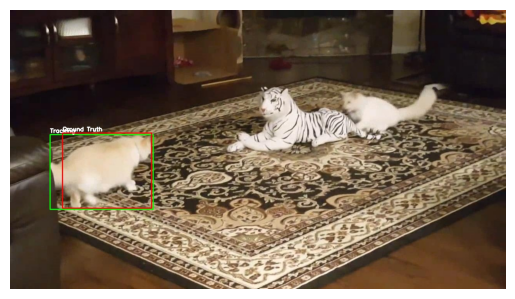

Above image is Showing the bounding box for the second frame of the sequence. RED IS GROUND TRUTH AND GREEN IS PREDICTED
Bounding boxes saved to trackresults_TM_seq5.txt file!
Results saved in data/seq5/results3 folder
Average Success for this Sequence: 0.7706816321535088
Average Euclidean Center distance between ground truth and tracked bounding for this Sequence: 18.038112211269468
Precision at 20px: 0.4867
Precision at 50px: 0.9733
Precision at 100px: 1.0000
Precision at 200px: 1.0000


In [81]:
# Path to images
images_folder = "data/seq5/img/"
image_files = sorted(glob.glob(f"{images_folder}/*.jpg"))

# Define output folder and file
output_dir = "results/3_improved/"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "trackresults_improved_seq5.txt")


with open("data/seq5/firsttrack.txt", "r") as file:
    gt_bbox = list(map(int, file.readline().strip().split(",")))  # x, y, w, h
print(f"Initialized Ground Truth: {gt_bbox}")

ground_truth_file = "data/seq5/groundtruth.txt"

with open(ground_truth_file, "r") as file:
    gt_bboxes = [list(map(int, line.strip().split(","))) for line in file.readlines()]



prev_id = None  # Store the object ID of the target object
prev_bbox = gt_bbox 

detection_lost = False

# EKF State [x, y, w, h, vx, vy]
state = np.array([gt_bbox[0], gt_bbox[1], gt_bbox[2], gt_bbox[3], 0, 0])  # Initial position and zero velocity
P = np.eye(6) * 500  # Initial covariance

# State Transition Matrix (Constant velocity model)
dt = 1  # Time step
F = np.array([
    [1, 0, 0, 0, dt, 0],  # x = x + vx * dt
    [0, 1, 0, 0, 0, dt],  # y = y + vy * dt
    [0, 0, 1, 0, 0, 0],   # width (constant)
    [0, 0, 0, 1, 0, 0],   # height (constant)
    [0, 0, 0, 0, 1, 0],   # velocity x
    [0, 0, 0, 0, 0, 1]    # velocity y
])

# Process noise covariance matrix (Assuming noise in position and velocity)
q_var = 2  # Variance of noise
Q = np.array([
    [q_var, 0, 0, 0, 0, 0],
    [0, q_var, 0, 0, 0, 0],
    [0, 0, q_var, 0, 0, 0],
    [0, 0, 0, q_var, 0, 0],
    [0, 0, 0, 0, q_var, 0],
    [0, 0, 0, 0, 0, q_var]
])

H = np.eye(6)  # Measurement function
R = np.eye(6) * 10  # Measurement noise

kf = ExtendedKalmanFilter(dim_x=6, dim_z=6)
kf.x = state
kf.F = F
kf.P = P
kf.Q = Q
kf.H = H
kf.R = R

boundingboxresults = []
ious = []
centers = []
for idx, image_path in enumerate(image_files):
    # Detect objects
    detections = detect_objects(image_path, threshold=0.2)

    # Load image
    image = cv2.imread(image_path)

    # Predict next state using EKF
    kf.predict()

    best_bbox = None

    if detections:
        if prev_bbox is not None:
            # Find best matching bounding box
            best_bbox = max(detections, key=lambda bbox: compute_iou(bbox[0], prev_bbox), default=None)

            if best_bbox and compute_iou(best_bbox[0], prev_bbox) > 0.3:
                detection_lost = False  # Detection is back
                prev_bbox = best_bbox[0]

                # EKF Update
                measurement = np.array([prev_bbox[0], prev_bbox[1], prev_bbox[2], prev_bbox[3], 0, 0])  # No velocity info
                kf.update(measurement, HJacobian, Hx)
            else:
                best_bbox = None

    if not best_bbox:
        detection_lost = True
        prev_bbox = kf.x[:4]  # Use predicted state when detection is lost

    # Draw bounding box
    x, y, w, h = map(int, prev_bbox)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(image, "Tracking" if not detection_lost else "Predicting", (x, y - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    
    boundingboxresults.append((x, y, w, h))

        # Draw ground truth bounding box (red)
    if idx < len(gt_bboxes):
        gt_x, gt_y, gt_w, gt_h = gt_bboxes[idx]
        cv2.rectangle(image, (gt_x, gt_y), (gt_x + gt_w, gt_y + gt_h), (0, 0, 255), 2)
        cv2.putText(image, "Ground Truth", (gt_x, gt_y - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    
    #Compute the IOU between the predicted and ground truth bounding boxes, and add it to a list so i can average it later
    
    iou = compute_iou(prev_bbox, gt_bboxes[idx]) if idx < len(gt_bboxes) else 0
    #print(f"IOU: {iou}")
    ious.append(iou)

    center = bbox_center(prev_bbox)
    gt_center = bbox_center(gt_bboxes[idx]) if idx < len(gt_bboxes) else None
    if gt_center is not None:
        distance = np.linalg.norm(center - gt_center)
        centers.append(distance)
        #print(f" Precision: {distance}")
       

    
    # Save the tracked frame
    output_path = f"data/seq5/results3/{os.path.basename(image_path)}"
    cv2.imwrite(output_path, image)

    

    print(f"Saved tracked frame: {output_path}")

#Save the tracking results
with open(output_file, "w") as file:
    for bbox in boundingboxresults:
        file.write(f"{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]}\n")

print(f"Object detection with association saved in {output_file}")


img = mpimg.imread('data/seq5/results3/00000002.jpg')  # Replace with your image file path
#img_rgb = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.show()

print("Above image is Showing the bounding box for the second frame of the sequence. RED IS GROUND TRUTH AND GREEN IS PREDICTED")

print("Bounding boxes saved to trackresults_TM_seq5.txt file!")
print ("Results saved in data/seq5/results3 folder")
print(f"Average Success for this Sequence: {np.mean(ious)}")
print(f"Average Euclidean Center distance between ground truth and tracked bounding for this Sequence: {np.mean(centers)}")

# Define thresholds
thresholds = [20, 50, 100, 200]

# Compute precision for each threshold
for t in thresholds:
    precision = sum(d < t for d in centers) / len(centers)
    print(f"Precision at {t}px: {precision:.4f}")
